In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError



np.random.seed(42)

In [32]:
df = pd.read_csv('./data/jj.csv')
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


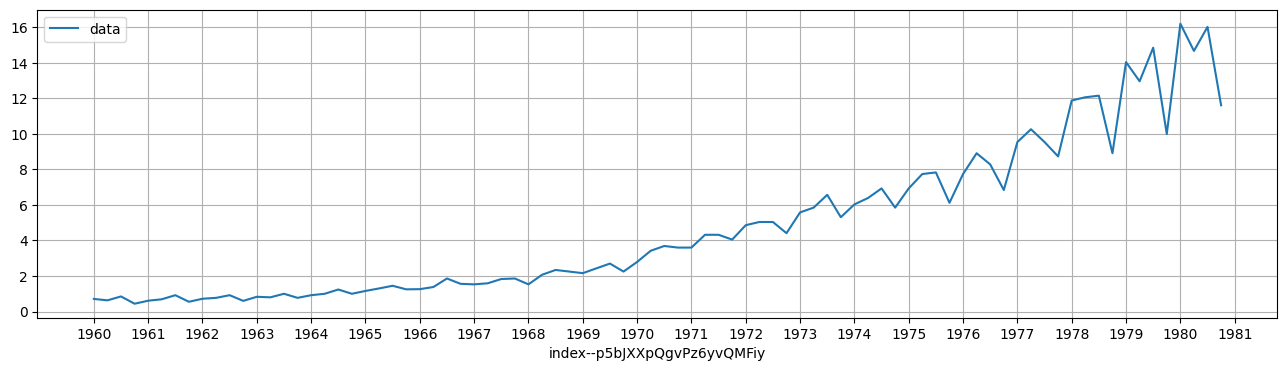

In [103]:
ax = df.plot( figsize=(16,4) )
ax.set_xticks( np.arange(0, 86, 4), pd.date_range(start='1960-01-01', end='1982-01-01', freq='Y').strftime('%Y'))
ax.grid()

In [105]:
adf_result = adfuller(df.data)
adf_result

(2.742016573457475,
 1.0,
 11,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 82.63760283301104)

In [107]:
eps_diff = np.diff(df.data, n=1)
adf_result = adfuller(eps_diff)
adf_result

(-0.40740976363803183,
 0.9088542416911329,
 10,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 89.2131713403821)

In [110]:
eps_diff = np.diff(df.data, n=2)
adf_result = adfuller(eps_diff)
adf_result

(-3.5851628747931596,
 0.006051099869603576,
 9,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 87.33900055833038)

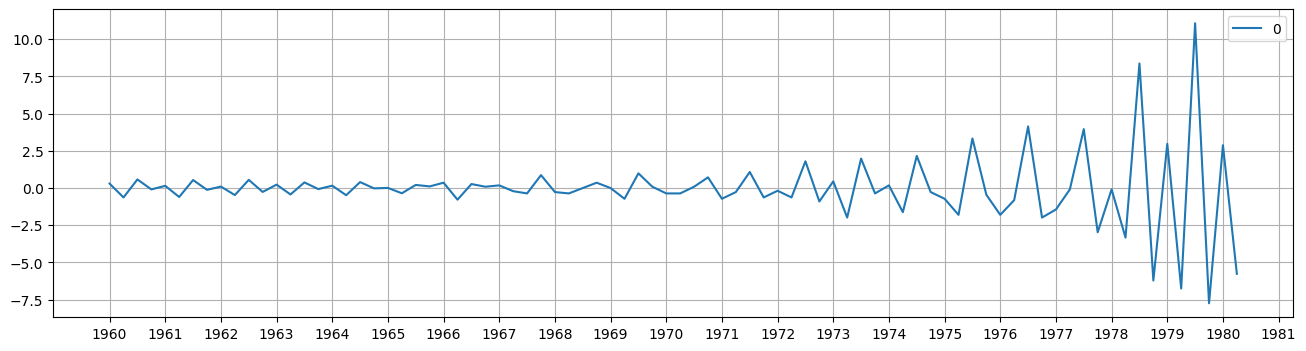

In [112]:
ax = pd.DataFrame(eps_diff).plot( figsize=(16,4) )
ax.set_xticks( np.arange(0, 86, 4), pd.date_range(start='1960-01-01', end='1982-01-01', freq='Y').strftime('%Y'))
ax.grid()

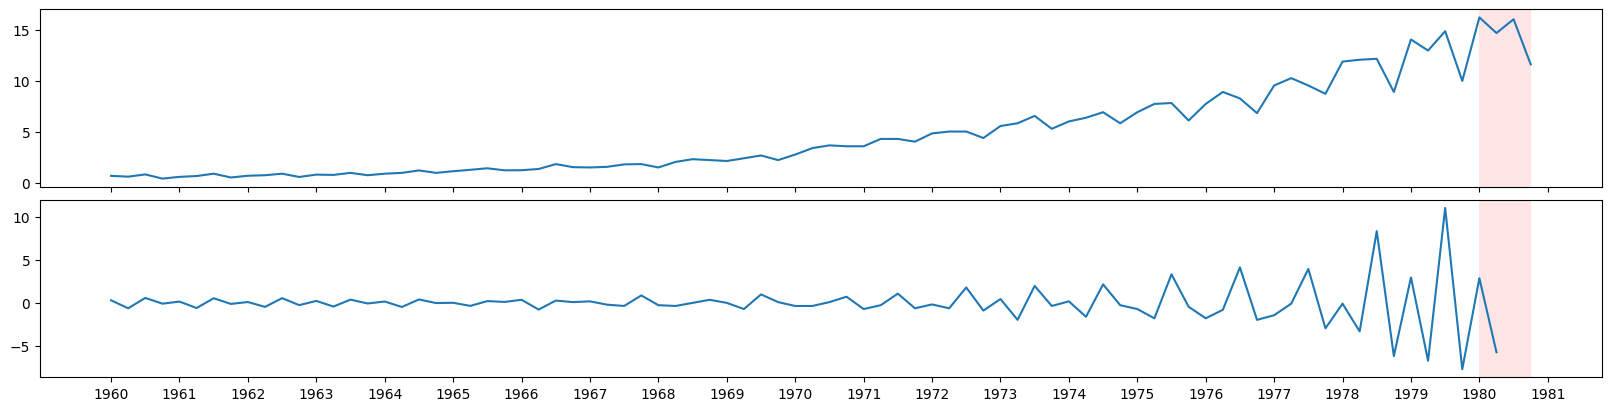

In [121]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4),  layout='constrained')
ax1.plot(df.data )
ax1.axvspan(80, 83, facecolor='red', alpha=0.1)
ax1.set_xticks( np.arange(0, 86, 4), pd.date_range(start='1960-01-01', end='1982-01-01', freq='Y').strftime('%Y'))
ax2.plot(pd.DataFrame(eps_diff))
ax2.axvspan(80, 83, facecolor='red', alpha=0.1)

plt.show()

In [122]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['PQ', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [123]:
order_list = list(product(range(0, 4, 1), range(0, 4, 1)))
d = 2

In [124]:
train = df.data[:-4]
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,PQ,AIC
0,"(3, 3)",115.272286
1,"(3, 1)",115.624981
2,"(3, 2)",115.672007
3,"(3, 0)",154.430623
4,"(0, 3)",194.654716
5,"(0, 2)",209.274551
6,"(2, 3)",220.666930
7,"(1, 3)",228.267854
8,"(1, 2)",228.935822
9,"(2, 2)",229.974688


In [136]:
model = SARIMAX(train, order=(result_df.head(1).PQ.item()[0],2,result_df.head(1).PQ.item()[1]))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.636
Date:                Tue, 13 Aug 2024   AIC                            115.272
Time:                        11:06:28   BIC                            131.769
Sample:                             0   HQIC                           121.876
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9996      0.037    -27.148      0.000      -1.072      -0.927
ar.L2         -0.9875      0.040    -24.642      0.000      -1.066      -0.909
ar.L3         -0.9756      0.026    -37.444      0.0

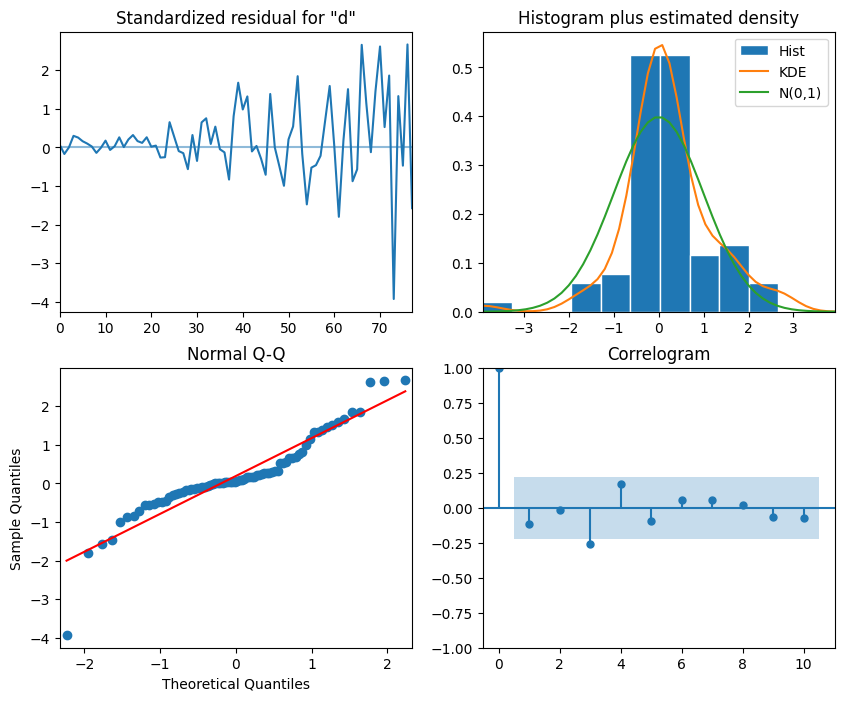

In [138]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [139]:
residuals = model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

      lb_stat  lb_pvalue
1    1.718445   0.189893
2    1.721627   0.422818
3    7.301074   0.062896
4    9.283049   0.054401
5    9.908667   0.077865
6   10.141575   0.118815
7   10.387055   0.167680
8   10.419805   0.236788
9   10.756892   0.292742
10  11.198764   0.342244


In [171]:
test = df.iloc[-4:]
test['naive_seasonal'] = df.data.iloc[76:80].values
test['ARIMA_pred'] = model_fit.get_prediction(80, 83).predicted_mean
test

,date,data,naive_seasonal,ARIMA_pred
index--p5bJXXpQgvPz6yvQMFiy,,,,
80,1980-01-01,16.20,14.04,15.854993
81,1980-04-01,14.67,12.96,14.376496
82,1980-07-02,16.02,14.85,16.368254
83,1980-10-01,11.61,9.99,11.679093


Text(0.5, 0, 'Date')

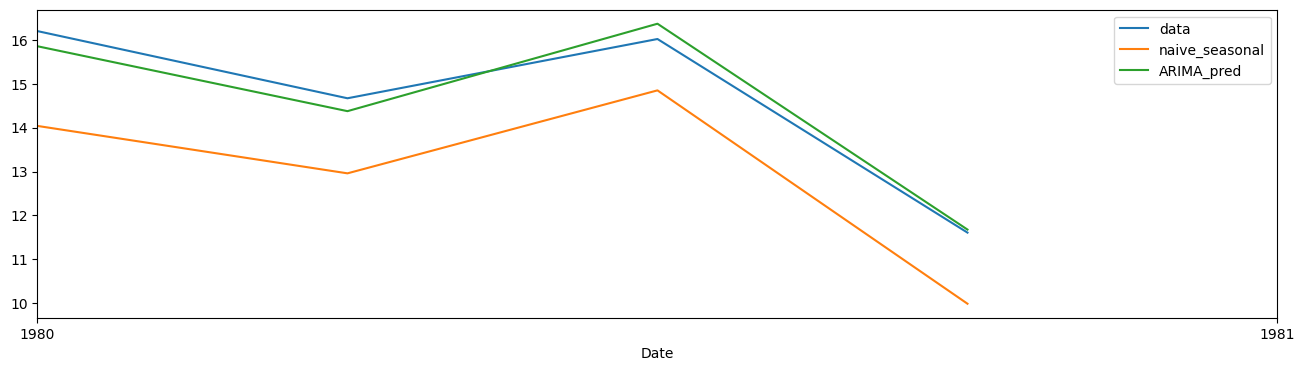

In [172]:
ax = test.plot(figsize=(16,4), layout='constrained')
ax.set_xticks( np.arange(0, 86, 4), pd.date_range(start='1960-01-01', end='1982-01-01', freq='Y').strftime('%Y'))
ax.set_xlim(80, 84)
ax.set_xlabel('Date')

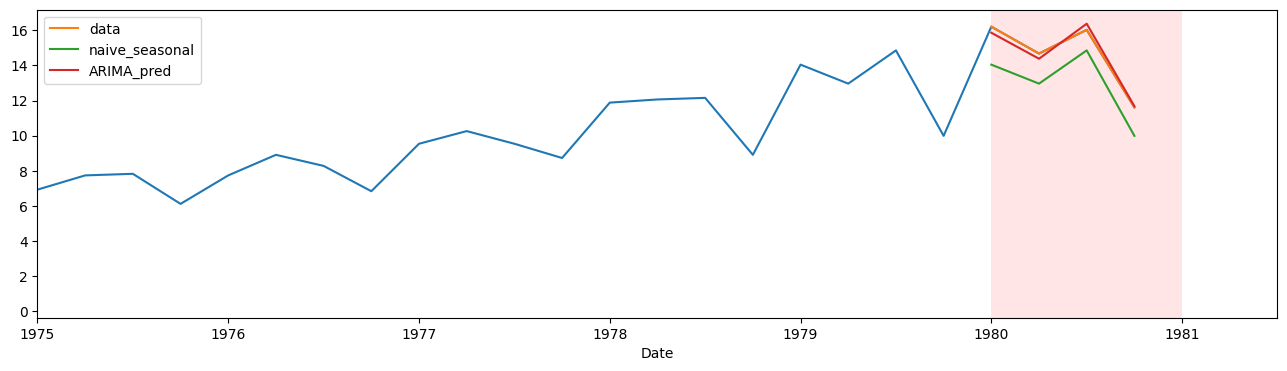

In [173]:
ax = df.data.plot( figsize=(16,4),  layout='constrained' )
test.plot( ax = ax)
ax.axvspan( 80, 84, facecolor='red', alpha=0.1)
ax.set_xticks( np.arange(0, 86, 4), pd.date_range(start='1960-01-01', end='1982-01-01', freq='Y').strftime('%Y'))
ax.set_xlim(60, 86)
ax.set_xlabel('Date')

plt.show()

In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 80 to 83
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            4 non-null      object 
 1   data            4 non-null      float64
 2   naive_seasonal  4 non-null      float64
 3   ARIMA_pred      4 non-null      float64
dtypes: float64(3), object(1)
memory usage: 260.0+ bytes


In [220]:
from torchmetrics.regression import MeanAbsoluteError

mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_naive_seasonal = torch.FloatTensor( test['naive_seasonal'].values)
predict_ARIMA = torch.FloatTensor( test['ARIMA_pred'].values)
target = torch.FloatTensor(test['data'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_naive_seasonal, target ).item()
maes['mae_ARIMA'] = mean_absolute_error( predict_ARIMA, target ).item()


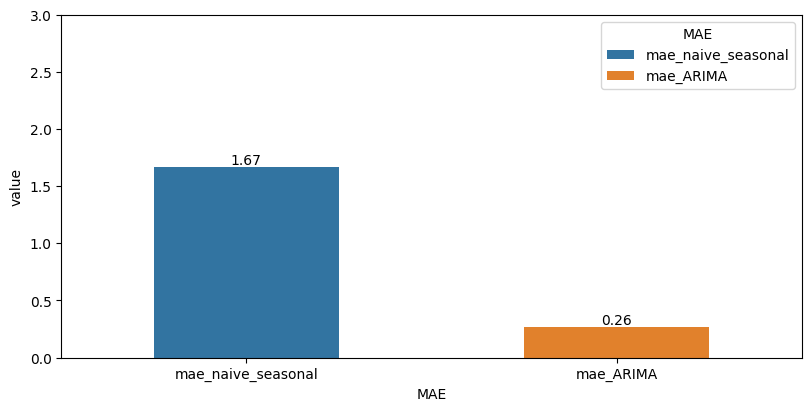

In [221]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 3)
ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [224]:
from torchmetrics import MeanAbsolutePercentageError
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_naive_seasonal = torch.FloatTensor( test['naive_seasonal'].values)
predict_ARIMA = torch.FloatTensor( test['ARIMA_pred'].values)
target = torch.FloatTensor(test['data'].values)

mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_naive_seasonal, target).item()
mapes['mape_ARIMA'] = mean_abs_percentage_error( predict_ARIMA, target).item()
mapes

{'mape_naive_seasonal': 0.11561658978462219, 'mape_ARIMA': 0.01724841259419918}

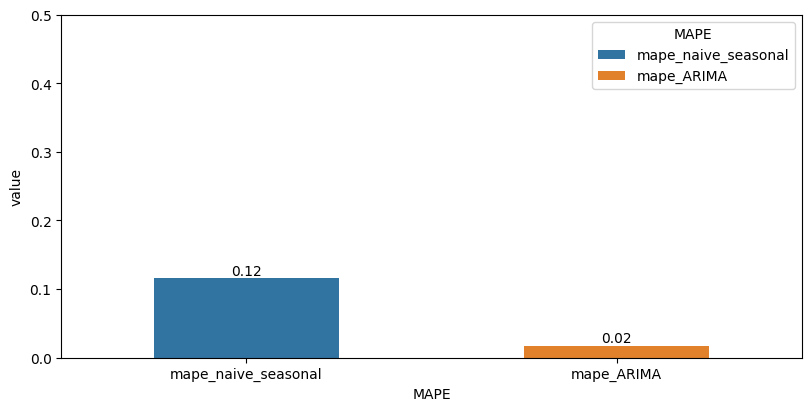

In [225]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.5)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)